# How to Prepare Your Data for AUTOENCODIX
In this tutorial we'll show `AUTOENCODIX` deals with different types of data the different ways to pass data into the pipeline.

**IMPORTANT**

> This tutorial explains mainly the type of data we allow and how to format the data, so that AUTOENCODIX can work with it. If you're unfamilar with general concepts,  
> we recommend to follow the `Getting Started - Vanillix` Tutorial first.

## What you'll learn
We'll cover:
- our general data logic
- how to pass data from files for different data modalities
- how to pass data directly into our pipeline
- differences between paired and unpaired data
- how our preprocessing works and how to skip it

## Data Model Theory
There are `two main ways` to pass data to `AUTOENCODIX` and we support `three main data modalities`. For this main modalities, we offer `seven main use cases`. 
Besides that you can chose if we should preprocess the data or you want to start with training the models directly.  


The `two main ways` to pass data are:  
- providing a file path in the config.
- passing the data directly to our pipeline.
<br><br>

The `three main data modalities` are:
- tabular numeric data  
- sparse numeric data (Single Cell) 
- image data

The `seven main use cases are`:
-  combining multi-omics data from single cell sequencing.
-  combining multi-omics data from bulk sequencing (e.g. mRNA and methylation).
-  "translating" between bulk sequencing data.
-  "translating" bulk and image an vice versa.
-  "translating" between single cell data.
-  training an image autoencoder. 
  
We encode these cases in our `DataCase` class and you need to specify in the config which `DataCase` you have. This is shown in the code in the next section.
``

The general way to feed data to our pipeline is independent of the specific model (Varix, XModalix, etc.). There might be minor pipeline specfic requirements, for example for  `Ontix`, we won't cover these here, please refer to the Tutorials of the specfic pipeline. Here we use `XModalix`  and `Varix` as an example. 

## 1) Passing Data from File
Depending on which pipeline you use, you have different will be interested in one of our `seven main use cases` as described above.
<br><br>
Regardless of the use case, the principle of passing data is always the same, just your files types will differ and you need to specify the use case in the config via the `DataCase`:
```python
class DataCase(str, Enum):
    MULTI_SINGLE_CELL = "Multi Single Cell"
    MULTI_BULK = "Multi Bulk"
    BULK_TO_BULK = "Bulk<->Bulk"
    IMG_TO_BULK = "IMG<->Bulk"
    SINGLE_CELL_TO_SINGLE_CELL = "Single Cell<->Single Cell"
    SINGLE_CELL_TO_IMG = "Single Cell<->IMG"
    IMG_TO_IMG = "IMG<->IMG" # standard image autoencoder.

```
#### 1.1 Combining mulit-omics data from bulk-sequencing
First we need to prepare our config object. We can (a) directly provide an object in python, or (b) provide an YAML file. We show option (a). For (b) refer to [1].


ATTENTION:
If you use `.txt` or `.csv` files, it is best practice to add the `sep` parameter. If none is given, the reader will try to auto-detect the separator, which is error prone.
This would loke like:

**IMPORTANT** 
>For all your bulk data files, we expect the first column to be some kind of unique sample id. Please prepare the data accordingly.

[1] Tutorials/DeepDives/ConfigTutorial.ipynb <br>

**First make sure we are in the root of our package:**

In [5]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")


Changed to: /Users/maximilianjoas/development/autoencodix_package


**Now we can perpare the config:**
> Besides the actual data files, we expect one `annotation` file with metadata. We add the param `data_type` and pass `ANNOTATION` to it. See code below.
> If you have columns inside the `ANNOTATION` data which information you want to use later in downstream visualization or evaluation task, plese specify them with the `annotation_columns` parameter of the `DataConfig`. This will prevent errors later, because we will handle NaNs in preprocessing for this columns.

reading parquet: data/raw/data_mrna_seq_v2_rsem_formatted.parquet
reading parquet: data/raw/data_methylation_per_gene_formatted.parquet
reading parquet: data/raw/data_clinical_formatted.parquet
anno: paired has shape: (10013, 54) before drop na
anno: paired has shape: (10013, 54) after drop na
anno key: paired


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_trainer.py:107: UserWarning: increased batch_size to 33 for trainset, to avoid dropping samples and having batches (makes trainingdynamics messy with missing samples per epoch) of size one (fails for Models with BachNorm)
  warnings.warn(


Epoch 1 - Train Loss: 23.6214
Sub-losses: recon_loss: 23.6214, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 125.0768
Sub-losses: recon_loss: 125.0696, var_loss: 0.0072, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 20.1615
Sub-losses: recon_loss: 20.1267, var_loss: 0.0348, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 20.4183
Sub-losses: recon_loss: 20.2117, var_loss: 0.2066, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 3 - Train Loss: 19.2658
Sub-losses: recon_loss: 18.6605, var_loss: 0.6053, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Epoch 3 - Valid Loss: 18.1870
Sub-losses: recon_loss: 17.6782, var_loss: 0.5087, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Creating plots ...


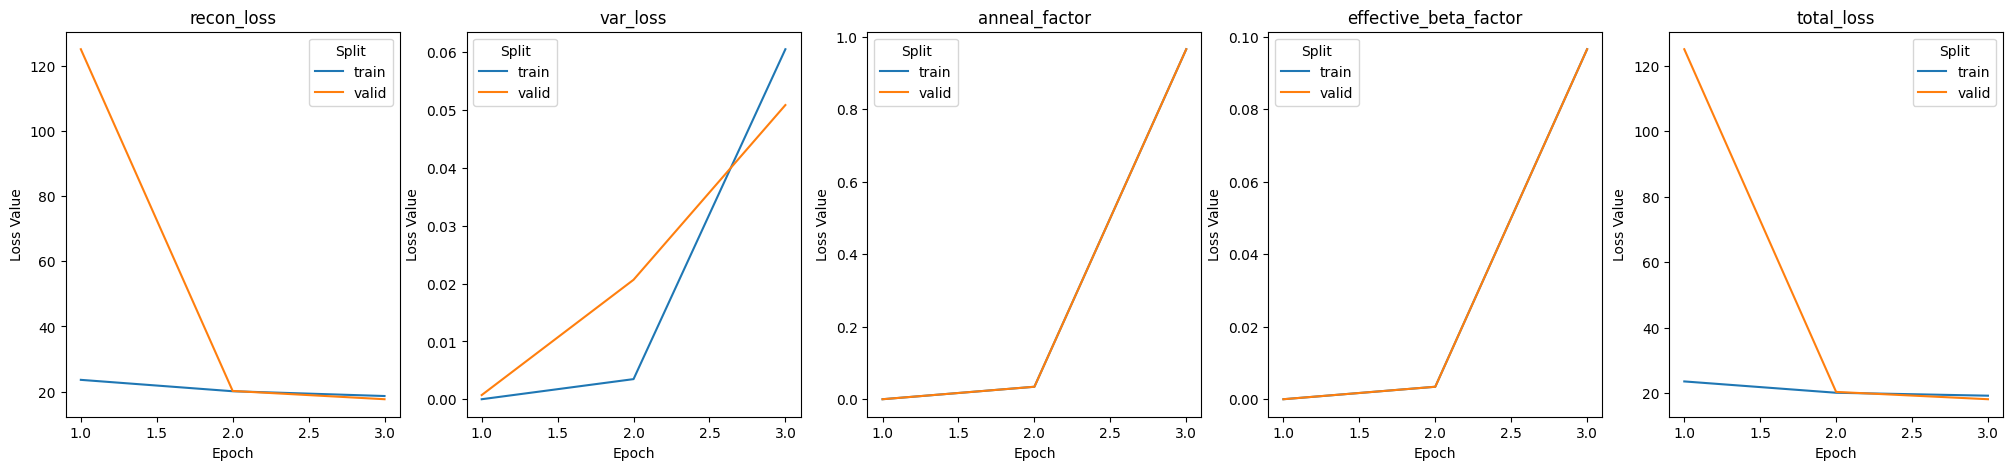

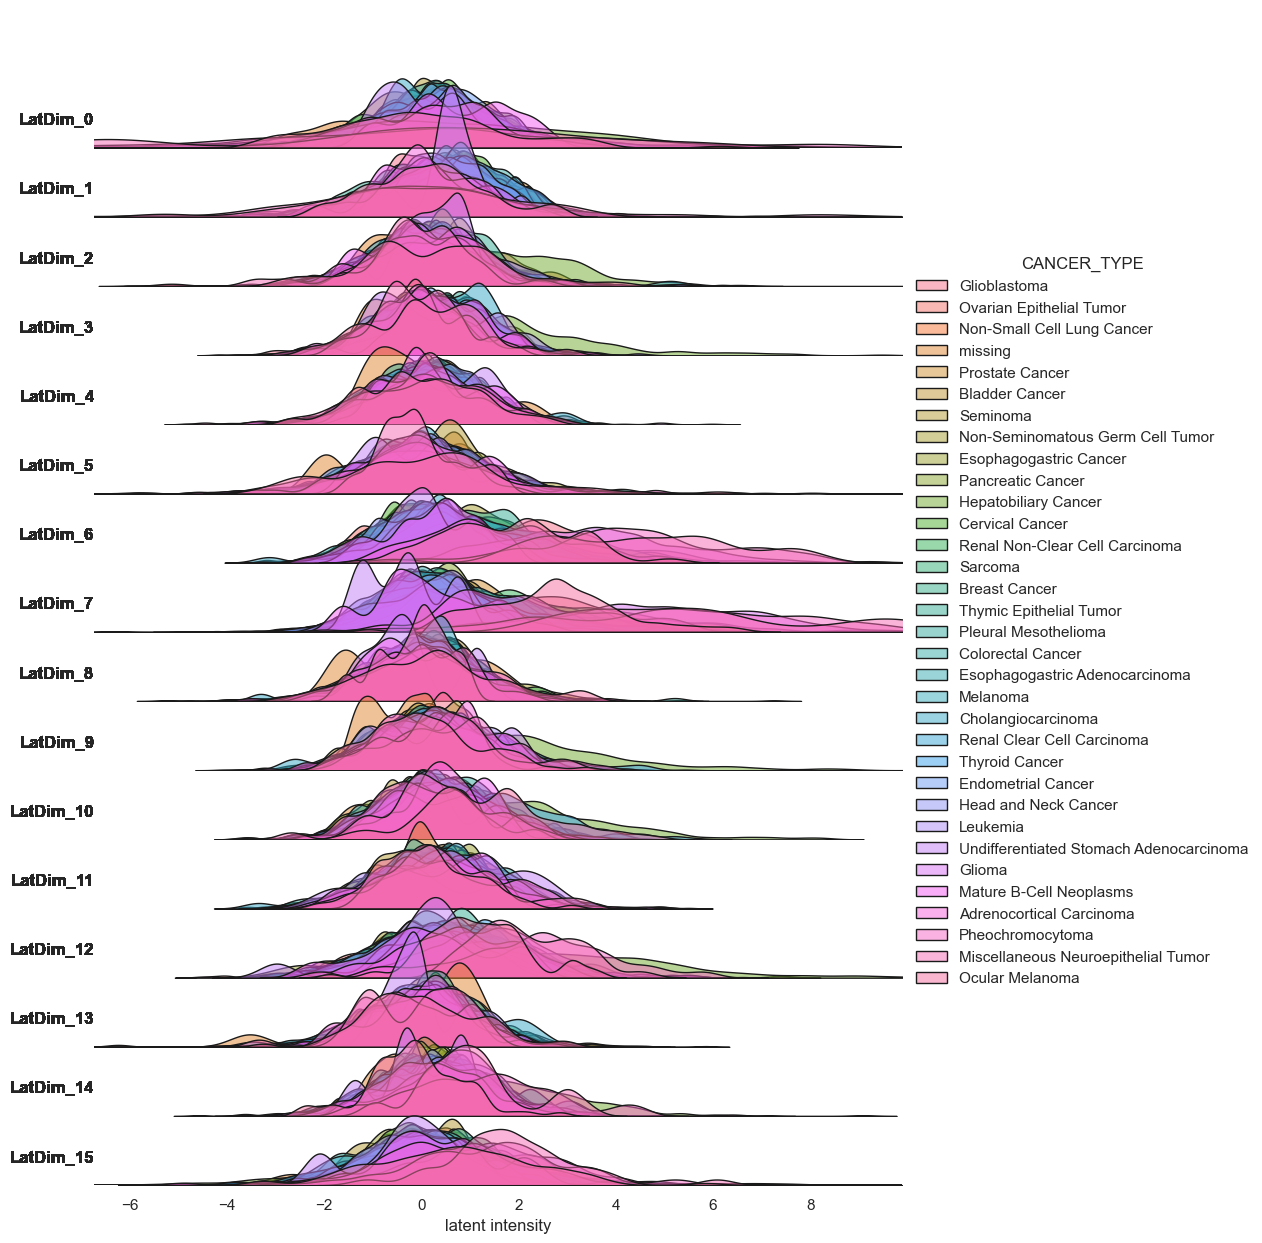

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


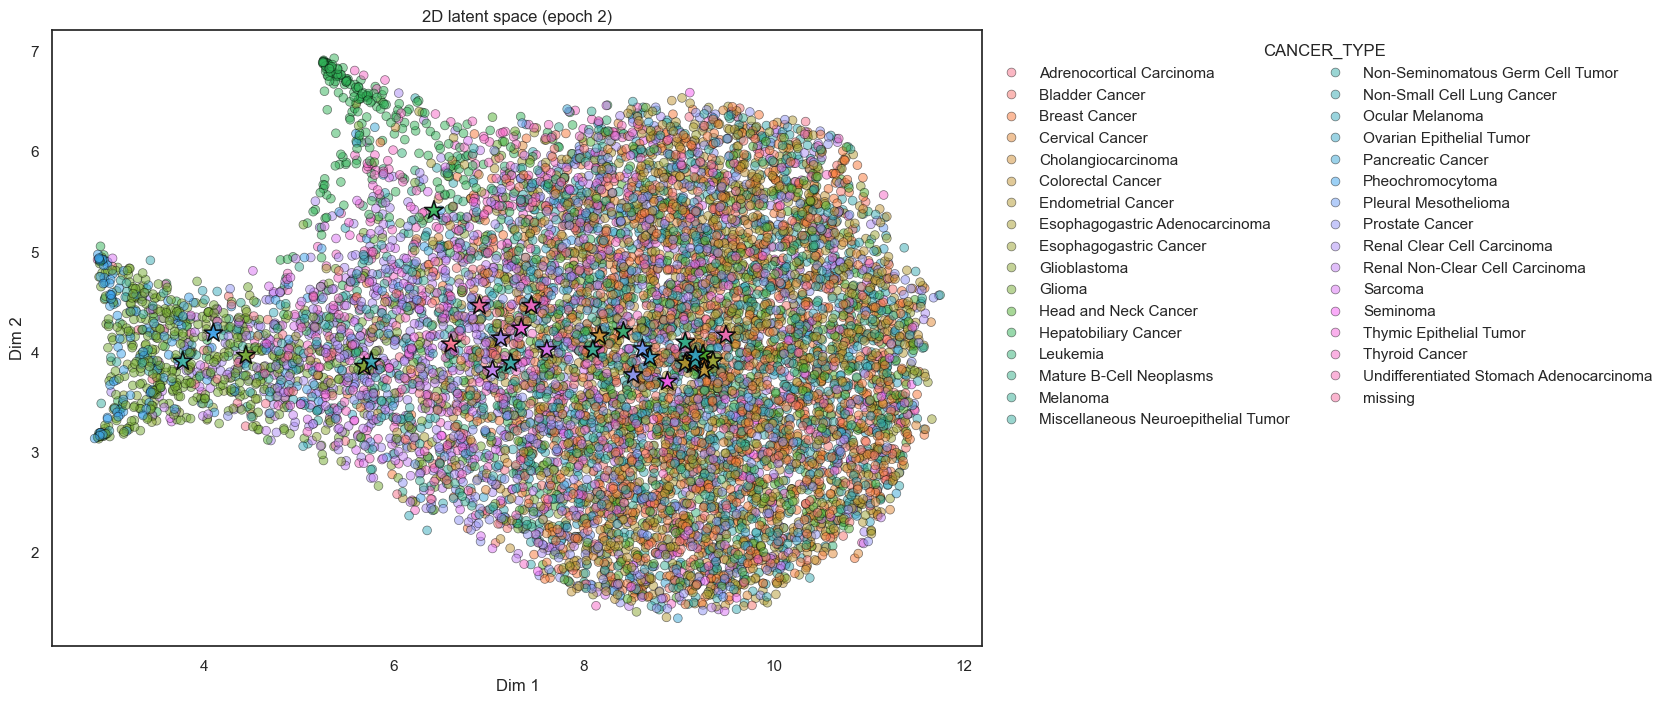

In [2]:
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase
from autoencodix.configs import VarixConfig

# First we need to define our file paths
root_dir = os.path.join("data/raw")
meth_file = "data_methylation_per_gene_formatted.parquet"
mrna_file = "data_mrna_seq_v2_rsem_formatted.parquet"
clin_file = "data_clinical_formatted.parquet"


"""
Our config class has the attribute `data_config`.
Here, we fill the `data_info` Dict, by defining names for our data modalities ("RNA" for example).
The value of this Dict is a instance of the `DataInfo` class. All we need to pass here is a `file_path` argument.
"""
data_config = DataConfig(
    annotation_columns=["CANCER_TYPE"],
    data_info={
        "RNA": DataInfo(file_path=os.path.join(root_dir, mrna_file)),
        "METHYLATION": DataInfo(file_path=os.path.join(root_dir, meth_file)),
        "CLINICAL": DataInfo(
            file_path=os.path.join(root_dir, clin_file), data_type="ANNOTATION"
        ),
    },
)

"""
Lastly, we pass our data_config to the VarixConfig. Remember to pass the appropriate `DataCase`.
"""
bulk_config = VarixConfig(data_config=data_config, data_case=DataCase.MULTI_BULK)
varix = acx.Varix(config=bulk_config)

result_varix = varix.run()
varix.show_result(params=["CANCER_TYPE"])

#### 1.2 Use Single Cell Data
This works analog to bulk/tabular data. You probably will pass `h5ad` files instead of parquet or csv files.  
For single cell data you most likely only use one data modality, so the term `MULTI_SC` is a bit misleading from our DataCase; think of it as 1-n modalities you can pass. Also, we most likely don't have an `annotation` file, because this information is already encoded in the `h5ad` file.
 **Note:**
> It is best practice to add the `is_single_cell` param to the DataInfo of the modality.

In [ ]:
filepath = "data/raw/Sc-2-mini.h5ad"
data_config = DataConfig(
    annotation_columns=["cell_type"],
    data_info={"SC": DataInfo(file_path=filepath, is_single_cell=True)},
)
sc_config = VarixConfig(data_config=data_config, data_case=DataCase.MULTI_SINGLE_CELL)
varix_sc = acx.Varix(config=sc_config)
result_sc = varix_sc.run()

Number of common cells: 4554
Index(['author_cell_type', 'age_group', 'donor_id', 'nCount_RNA',
       'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile',
       'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id',
       'cell_type_ontology_term_id', 'development_stage_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'suspension_type', 'is_primary_data',
       'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism',
       'sex', 'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')
mudata: View of MuData object with n_obs × n_vars = 4554 × 9009
  obs:	'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_t

**Special Case for Visualization**
As we explained before we can define a column/columns that we want to use for visualization. We chose the `cell_type` before. Internally the column gets the prefix of the name of the data modality that we defined in the `DataInfo` dict, so if we want to visualize the column we need to hadd this prefix to the column name `SC:`.  
> This will probably be fixed in the future, so that you can just pass the column name without prefix.

Creating plots ...


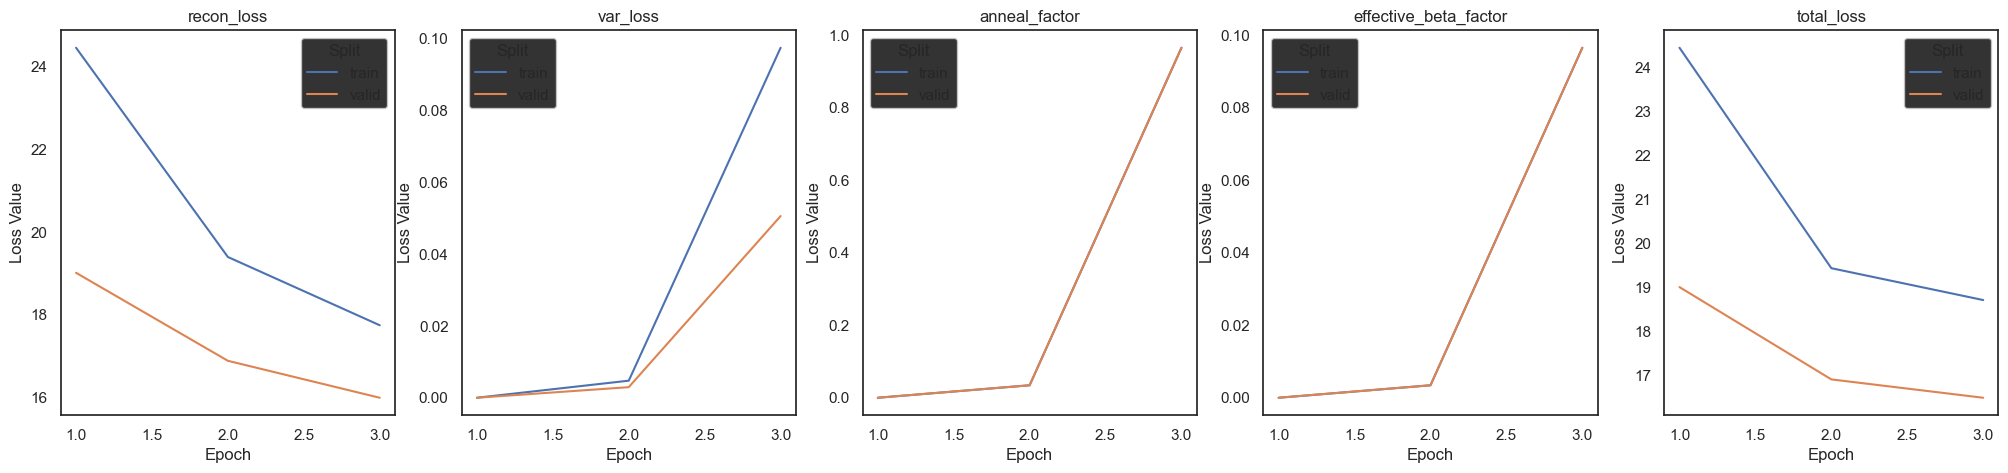

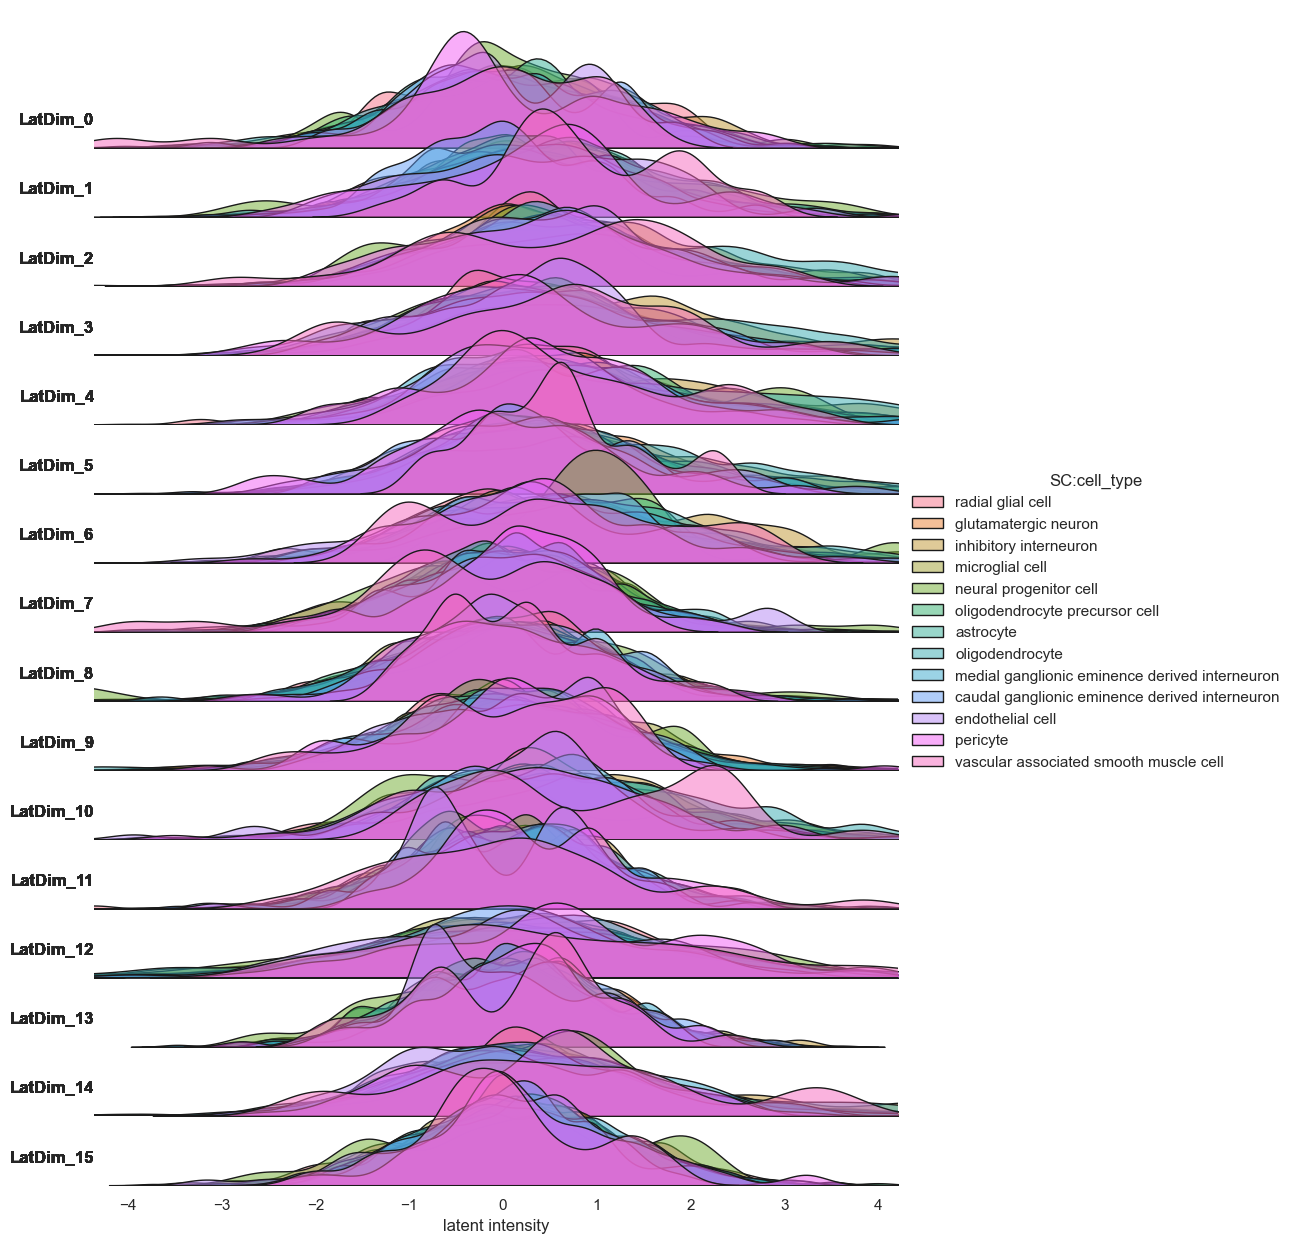

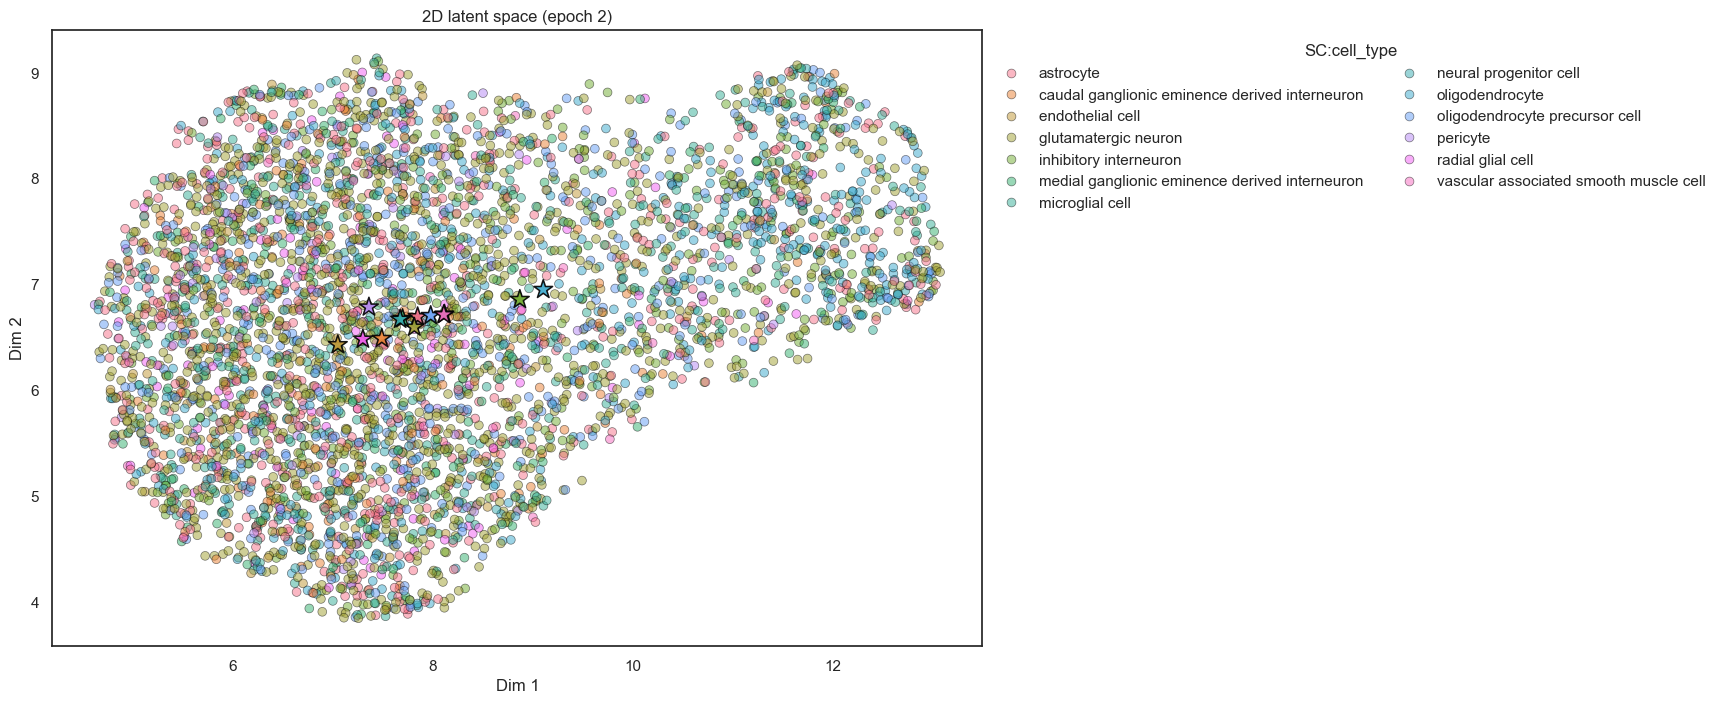

In [ ]:
varix_sc.show_result(params=["SC:cell_type"])

#### 1.3 Working with Images
This does not work too different as previous cases. The only difference is that we provide a directory path, where the image files are located instead of a path to a single file.  
We allow the following image files (case INDEPENDENT):
`".jpg", ".jpeg", ".png", ".tif", ".tiff"`.  
So be sure there are files with the supported extension in the directory you specify.

You also have the option to specify a image size (only quadratic values are allowed).



In [4]:
from autoencodix.configs import XModalixConfig
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase

from autoencodix.configs import VarixConfig


clin_file = os.path.join("data/XModalix-Tut-data/combined_clin_formatted.parquet")
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")

xmodalix_config = XModalixConfig(
    checkpoint_interval=5,
    class_param="CANCER_TYPE_ACRONYM",
    epochs=6,
    requires_paired=False,
    pretrain_epochs=2,
    skip_preprocessing=True,
    data_case=DataCase.IMG_TO_BULK,
    data_config=DataConfig(
        data_info={
            "img": DataInfo(
                file_path=img_root,
                data_type="IMG",
                scaling="MINMAX",
                translate_direction="to",  # For XModalix you need to specify "to" or "from"
                img_width_resize=32,
                img_height_resize=32,
                pretrain_epochs=2,
                # extra_anno_file=imganno_file,
            ),
            "rna": DataInfo(
                file_path=rna_file,
                data_type="NUMERIC",
                scaling="MINMAX",
                translate_direction="from",
            ),
            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        },
    ),
)

xmodalix = acx.XModalix(config=xmodalix_config)
result = xmodalix.run()

reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet


FileNotFoundError: [Errno 2] No such file or directory: 'data/XModalix-Tut-data/combined_rnaseq_formatted.parquet'

len of tensor-list: 711
len of tensor_ids: 711
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.20093869 0.07238387 0.09924041 ... 0.13999256 0.07429504 0.19656429]
 [0.20789738 0.07611202 0.100408   ... 0.14195243 0.07620231 0.20262189]
 [0.20998734 0.07641271 0.10147709 ... 0.14490645 0.07916685 0.20529911]]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


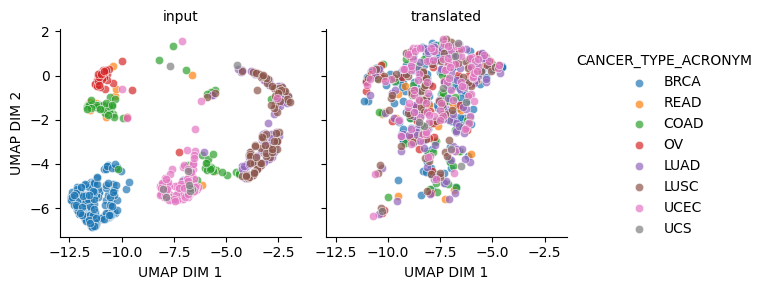

In [ ]:
fig = xmodalix._visualizer.show_2D_translation(
    result=result,
    translated_modality="img.img",
    split="test",
    param="CANCER_TYPE_ACRONYM",
    reducer="UMAP",
)

## 2) Passing Data Directly
If you want to read the data yourself, or the data comes from another script directly as Python object, we show how to prepare this data for `AUTOENCODIX`.   
We go over our `three main data modalities` as we did for the previous section.  

The main class for this is our `DataPackage` class. This serves as a container for pandas DataFrames and AnnData/MuData. Let's see in code how this works to make things more clear:

#### 2.1) Passing Numeric Tabular Data
Let's assume we have two data modalities as pd.DataFrames and one annotation file with metadata also as pd.DataFrame. The only requirements we have is that the data is numeric, for the data files. For the annotation we allo categorical variables too.

In [6]:
from autoencodix.utils.example_data import raw_protein, raw_rna, annotation
from autoencodix.data import DataPackage

print(f"Type of rna: {type(raw_rna)}")
raw_protein.head()

Type of rna: <class 'pandas.core.frame.DataFrame'>


,protein_0,protein_1,protein_2,protein_3,protein_4,protein_5,protein_6,protein_7,protein_8,protein_9,...,protein_70,protein_71,protein_72,protein_73,protein_74,protein_75,protein_76,protein_77,protein_78,protein_79
sample_0,-12.042401,0.087191,-2.569039,1.194324,3.232265,-0.849021,-2.456986,-4.714146,-0.330510,1.791241,...,1.298304,-0.888675,2.211052,0.704696,2.647467,3.053971,1.389405,-1.531050,-0.931632,-8.202654
sample_1,-5.774403,0.189626,-4.880973,0.945787,1.178465,-5.730645,-2.277935,-1.755148,-4.730100,0.394876,...,-4.046358,-3.408130,3.022748,-0.314424,2.378629,0.222959,-0.101802,4.570407,0.801779,-5.779545
sample_2,2.853659,-1.509067,-0.102335,-0.900886,-1.202590,1.023140,-0.556068,-0.431105,-3.262940,-0.705130,...,2.127268,2.228164,0.949771,0.055224,-5.031155,-2.850230,-3.012782,1.672382,0.657073,-0.844778
sample_3,3.409531,-0.221087,1.766617,3.460660,-1.476767,-0.344091,-3.543586,3.578511,-0.855364,2.385952,...,-2.032749,-1.866859,-0.718189,0.603248,2.518338,-0.300170,-3.655031,1.102813,0.516071,1.866424
sample_4,2.056824,-7.165520,1.986310,-2.968593,2.047759,-6.310128,2.237384,1.204833,-3.900744,0.986285,...,-2.756762,-2.793976,4.341621,-4.084905,-2.004152,7.571476,5.221252,1.209981,1.946205,-3.417621


In our DataPackage class we have four attributes:
- multi_bulk, any tabular numeric data comes here
- multi_sc
- annotation
- img

Each attribute holds a Dict in which we can pass our dataframes and assign a data modality key to it like:

In [7]:
my_dp = DataPackage(
    multi_bulk={"rna": raw_rna, "protein": raw_protein}, annotation={"anno": annotation}
)

The instance of `DataPackage` can be directly passed to our pipeline object via the data keyword argument.

In [8]:
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase
from autoencodix.configs import VarixConfig

config = VarixConfig(data_case=DataCase.MULTI_BULK)
varix = acx.Varix(data=my_dp, config=config)
result = varix.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: anno
Epoch 1 - Train Loss: 28.1900
Sub-losses: recon_loss: 28.1900, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 24.1868
Sub-losses: recon_loss: 24.1868, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 27.8245
Sub-losses: recon_loss: 27.8115, var_loss: 0.0130, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 25.2486
Sub-losses: recon_loss: 25.2434, var_loss: 0.0051, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 3 - Train Loss: 26.7782
Sub-losses: recon_loss: 26.4135, var_loss: 0.3647, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Epoch 3 - Valid Loss: 25.2896
Sub-losses: recon_loss: 25.1151, var_loss: 0.1745, anneal_factor: 0.9656, effective_beta_factor: 0.0966


You still can customize your config by providing a `DataConfig` with `DataInfo` as shown in [section 1](#11-combining-mulit-omics-data-from-bulk-sequencing)

In [ ]:
my_dp = DataPackage(
    multi_bulk={"rna": raw_rna, "protein": raw_protein}, annotation={"anno": annotation}
)
data_config = DataConfig(
    data_info={
        "rna": DataInfo(scaling="MINMAX"),
        "protein": DataInfo(scaling="MINMAX"),
    },
)

bulk_config = VarixConfig(data_config=data_config, data_case=DataCase.MULTI_BULK)
varix = acx.Varix(config=bulk_config, data=my_dp)
r = varix.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno: anno has shape: (500, 3) before drop na
anno: anno has shape: (500, 3) after drop na
anno key: anno
Epoch 1 - Train Loss: 11.8546
Sub-losses: recon_loss: 11.8545, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 4.8801
Sub-losses: recon_loss: 4.8801, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 9.8871
Sub-losses: recon_loss: 9.8717, var_loss: 0.0153, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 4.4273
Sub-losses: recon_loss: 4.4253, var_loss: 0.0020, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 3 - Train Loss: 8.9559
Sub-losses: recon_loss: 8.5318, var_loss: 0.4240, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Epoch 3 - Valid Loss: 4.6390
Sub-losses: recon_loss: 4.5283, var_loss: 0.1108, anneal_factor: 0.9656, effective_beta_factor: 0.0966


#### 2.2) Passing Single Cell Data
This works analog to the case above. Instead of pd.DataFrames, we pass `AnnData` or `MuData` for `scverse` to our DataPackage. It is also possible to pass `AnnData` or `MuData` directly to the pipeline

**Working with AnnData**

In [ ]:
from autoencodix.utils.example_data import sample_adata, sample_mudata

sample_adata

AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'cell_type', 'batch', 'donor', 'cell_cycle'

For AnnData this is now actually super simple, you can just put the `AnnData` object into the pipeline, without specifing the DataCase for Varix, because we can infer this from the pipeline type and the input data type for this case. We did not pass a config, which means we will use default parameters. 
  
Of course you can also define and pass a config

In [ ]:
varix = acx.Varix(data=sample_adata)
result = varix.run()

in handle_direct_user_data with data: <class 'anndata._core.anndata.AnnData'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 500
  1 modality
    user-data:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
Epoch 1 - Train Loss: 30.1757
Sub-losses: recon_loss: 30.1757, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 24.2905
Sub-losses: recon_loss: 24.2904, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 27.2304
Sub-losses: recon_loss: 27.2182, var_loss: 0.0122, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - 

**Working with MuData**
In some cases you want to combine multiple single cell modalities, here we expect a MuData object. This can be passed directly to the pipeline as shown for AnnData or via our DataPackage as shown in the tabular numeric case

In [2]:
sample_mudata

MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'

In [10]:
varix = acx.Varix(data=sample_mudata)
result = varix.run()

in handle_direct_user_data with data: <class 'mudata._core.mudata.MuData'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Epoch 1 - Train Loss: 28.3373
Sub-losses: recon_loss: 28.3373, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 22.6526
Sub-losses: recon_loss: 22.6526, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 25.5429
Sub-losses: recon_loss: 25.5281, var_loss: 0.0149, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 22.2296
Sub-losses: recon_loss: 22.2190, var_loss: 0.0106, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 3 - Train Loss: 24.6651
Sub-losses: recon_loss: 24.2199, var_loss: 0.4451, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Epoch 3 - Valid Loss: 21.6771
Sub-losses: recon_loss: 21.4006, var_loss: 0.2765, anneal_factor: 0.9656, effective_beta_factor: 0.0966


**Single Cell Specific Processing**
TODO

#### 2.3) Passing Image Data
We recommend to pass image data via a folder path in the config as shown in [section 1.3](#13-working-with-images).  
For completness, we show how one would pass images directly to the pipeline, but we don't recommend this.  

We store image data as a list where each item represents one image and each item is of our custom class `ImgData`

In [ ]:
from autoencodix.data import ImgData
from autoencodix.data.datapackage import DataPackage
import numpy as np
import pandas as pd

imgdata = [ImgData(img=np.array(1), sample_id="myImg", annotation=pd.DataFrame())]
dp = DataPackage({"IMG": imgdata})
# in real applications this will be a longer list of images

## 3) Note on Paired and Unpaired Data
When working with mutli-modal data it is common that not all data modalities are present for all samples. For most the models `Vanillix`, `Varix`, and `Ontix`, we require paired data due to inherent architecture constraints and remove samples that are not present in all data modalities.  

For the models `XModalix` and `Stackix` don't have the same arechitectural constraints. Thus, we can allow also unpaired data. This needs to be specified in the config via the param `requires_paired=False`.

## 4) Notes on Data Modality Sepcific Preprocessing and Skip Preprocessing

Depending on the data modality, our pipeline applies different preprocessing steps. We will give an overview of applied preprocessing techniques for our `three main data modalities`.

#### 4.1 Preprocessing for Tabular Numeric Data
The following steps are applied in that order:
- remove missing and NaN values from tabual numeric data
- consolidate missing and NaN to one "missing" class for the annotation columns (as specified with `annotation_columns` param in config) of the annotation dataframe
- split data into train/valid/test set according to the in the config defined ratios
- filter features based on the in the config defined filtering method. The statistical operations to filter the data are performed on the train data set to avoid data leakage from train to test/valid split. The learned filtering of train is then applied to the valit and test split
- fit a `sklearn` scaler on the train data, depending on the defined scaling algorithm (MinMax, Standard, etc). The fitted scaler is then applied to the valid and test split.
    - The filtering and scaling is also applied if you run the predict step with new unseen data.
- transform the data into a PyTorch dataset to be ready for training in PyTorch nn.Module  


#### 4.2 Preprocessing for Sparse Numeric Data (Single Cell)
The following steps are performed in that order:
- replace missing values with zeros
- apply two single cell specific processing steps if defined in the config:
    - filter cells based on a gene count, defined in   `min_genes` in the config via `sc.pp.filter_cells`
    - log transform, if specified in config in `log_transform`  via `sc.pp.log1p`
- from here we follow the preprocessing for tabular numeric data see above.
- we keep the data sparse in our PyTorch dataset until batch level. This prevent out-of-memory errors for large dataset when transforming from sparse to dense.


#### 4.3 Preprocessing for Image Data
For image data we preprocess the data as follows:
- split data into train/test/valid sets as defined in the config.
- resize the images to a quadratic image size that fits for our enocder depth or the specified width and height in the config.
- scale pixels depending on the defined scaling algorithm (MinMax, Standard, etc) image specific, not sklearn.
- transform data into a PyTorch dataset specialized for image data.

#### 4.4 Skipping Preprocessing
We allow to skip our preprocessing via the config param `skip_preprocessing`. However, we can't guarantee that there won't be `RunTimeErrors`. 
Errors shouldn't happen if your data does not contain `NaNs` and your loss function matches to our scaling. For example if you set `reconstruction_loss` to `bce`, be sure that your input data is between 0 and 1, because the last layer of our architecture is a Sigmoid.


## 5) Adding Custom Splits

Our standard preprocessing splits the data randomly into train/valid/test splits. The custom splits feature is currently depcrecated. We probably will add this as a feature to work as follows in the future:
```python
import numpy as np
from autoencodix.configs.default_config import DataCase

sample_data = np.random.rand(100, 10)
custom_train_indices = np.arange(75)  # we won't allow overlap between splits
custom_valid_indices = np.arange(75, 80)
custom_test_indices = np.arange(80, 100)

# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}
config = DefaultConfig(data_case=DataCase.MULTI_BULK)
van = acx.Vanillix(data=raw_bulk, custom_splits=custom_split, config=config)
van.preprocess()
van.fit()
```